In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR  # SVC(분류) 대신 SVR(회귀) 사용
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor  # XGBClassifier 대신 XGBRegressor 사용

# 2. 평가 지표: 회귀용 지표로 변경
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
# classification_report, accuracy_score 등은 삭제

import joblib

# 기초 설정
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 한글 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [2]:
from dotenv import load_dotenv
print(load_dotenv())

True


In [3]:
!kaggle competitions download -c playground-series-s4e9

playground-series-s4e9.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
import os
# 압축 파일 경로 (정방향 슬래시 사용)
zip_file_path = 'C:/Users/subin/github/playground-series-s4e9.zip'
# 압축을 풀 대상 디렉토리
extract_to_path = 'C:/Users/subin/github'
# zip 파일 열기 및 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)
    print(f"압축 해제 완료: {extract_to_path}")
# 해제된 파일 목록 확인
print("현재 폴더 파일 목록:", os.listdir(extract_to_path))

압축 해제 완료: C:/Users/subin/github
현재 폴더 파일 목록: ['.env', '.gitignore', 'ag_stable_model', 'catboost_info', 'DSWebApp', 'final_best_blend_submission.csv', 'FirstProject', 'Heosubin', 'Little-Sonny', 'playground-series-s4e9.zip', 'Practice', 'sample_submission.csv', 'submission_autogluon_stable.csv', 'submission_stacking.csv', 'super_stacking_v2.csv', 'test.csv', 'train.csv', '중고차 가격예측 1 copy.ipynb', '중고차 가격예측 1.ipynb']


In [5]:
trainPath = os.path.join(extract_to_path, 'train.csv')
testPath = os.path.join(extract_to_path, 'test.csv')
train_df = pd.read_csv(trainPath)
test_df = pd.read_csv(testPath)
train_df.head(5)
# test_df.head(10)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [6]:
train_df.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

## 🚗 중고차 데이터셋 컬럼 가이드

| 분류 | 컬럼명 | 설명 | 비고 |
| --- | --- | --- | --- |
| **식별 정보** | `id` | 차량의 고유 번호 | 분석 시 큰 의미는 없으나 중복 확인용으로 사용 |
|  | `brand` | 제조사 브랜드 (예: 현대, BMW, 테슬라) | 브랜드 인지도는 가격에 큰 영향을 미침 |
|  | `model` | 구체적인 차종 명칭 (예: 아반떼, 3시리즈, 모델3) | 세부 모델에 따라 가격 편차 발생 |
| **차량 스펙** | `model_year` | 출시 연도 (연식) | **핵심 지표.** 일반적으로 최근 연식일수록 비쌈 |
|  | `fuel_type` | 연료 타입 (가솔린, 디젤, 하이브리드, 전기 등) | 유지비와 직결되는 요소 |
|  | `engine` | 엔진 정보 (배기량, 기통 수 등) | 차량의 힘과 세금을 결정하는 요소 |
|  | `transmission` | 변속기 종류 (자동, 수동, DCT 등) | 운전 편의성과 연비에 영향 |
| **외관 & 내장** | `ext_col` | 외부 색상 (Exterior Color) | 흰색, 검은색 등 대중적인 색상이 인기가 많음 |
|  | `int_col` | 내부 시트/인테리어 색상 (Interior Color) | 내부 가죽 색상 등에 따른 선호도 차이 |
| **상태 & 이력** | `milage` | 주행 거리 (마일/킬로미터) | **핵심 지표.** 주행 거리가 짧을수록 가치가 높음 |
|  | `accident` | 사고 유무 및 사고 이력 | 감가상각의 가장 큰 요인 중 하나 |
|  | `clean_title` | 압류나 저당이 없는 깨끗한 권리 상태 여부 | 법적인 문제(체납 등)가 없는지 확인 |
| **타겟 데이터** | `price` | **판매 가격** | 우리가 예측하고자 하는 최종 목표값 |

---


In [7]:
train_df.isnull().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [8]:
train_df['engine'].unique()

array(['172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel',
       '252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel',
       '320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability', ...,
       '78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel',
       '139.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas',
       '313.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas'],
      dtype=object)

In [9]:
# 브랜드 이름 수정 매핑 사전
brand_mapping = {
    'Land': 'Land Rover',
    'Alfa': 'Alfa Romeo',
    'Aston': 'Aston Martin',
    'smart': 'Smart'
}

# 이름 일괄 수정
train_df['brand'] = train_df['brand'].replace(brand_mapping)

# 수정 후 확인
print(train_df['brand'].unique())

['MINI' 'Lincoln' 'Chevrolet' 'Genesis' 'Mercedes-Benz' 'Audi' 'Ford'
 'BMW' 'Tesla' 'Cadillac' 'Land Rover' 'GMC' 'Toyota' 'Hyundai' 'Volvo'
 'Volkswagen' 'Buick' 'Rivian' 'RAM' 'Hummer' 'Alfa Romeo' 'INFINITI'
 'Jeep' 'Porsche' 'McLaren' 'Honda' 'Lexus' 'Dodge' 'Nissan' 'Jaguar'
 'Acura' 'Kia' 'Mitsubishi' 'Rolls-Royce' 'Maserati' 'Pontiac' 'Saturn'
 'Bentley' 'Mazda' 'Subaru' 'Ferrari' 'Aston Martin' 'Lamborghini'
 'Chrysler' 'Lucid' 'Lotus' 'Scion' 'Smart' 'Karma' 'Plymouth' 'Suzuki'
 'FIAT' 'Saab' 'Bugatti' 'Mercury' 'Polestar' 'Maybach']


In [10]:
# 범주형 컬럼 결측치 처리
categorical_cols = train_df.select_dtypes(include=['object']).columns
train_df[categorical_cols] = train_df[categorical_cols].fillna('Unknown')
test_df[categorical_cols] = test_df[categorical_cols].fillna('Unknown')

# 수치형 컬럼 결측치 처리 (타겟 컬럼 'price' 제외)
# train_df에서 price를 제외한 수치형 컬럼만 추출
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
numeric_cols_no_price = numeric_cols.drop('price') if 'price' in numeric_cols else numeric_cols

# train 결측치 처리 (price 포함)
train_df[numeric_cols] = train_df[numeric_cols].fillna(-1)

# test 결측치 처리 (price 제외)
test_df[numeric_cols_no_price] = test_df[numeric_cols_no_price].fillna(-1)

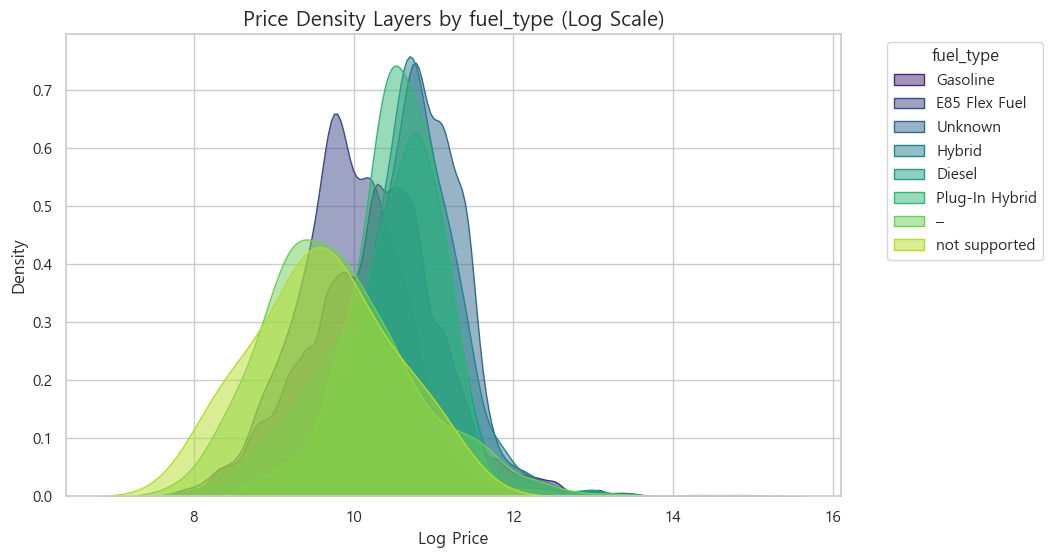

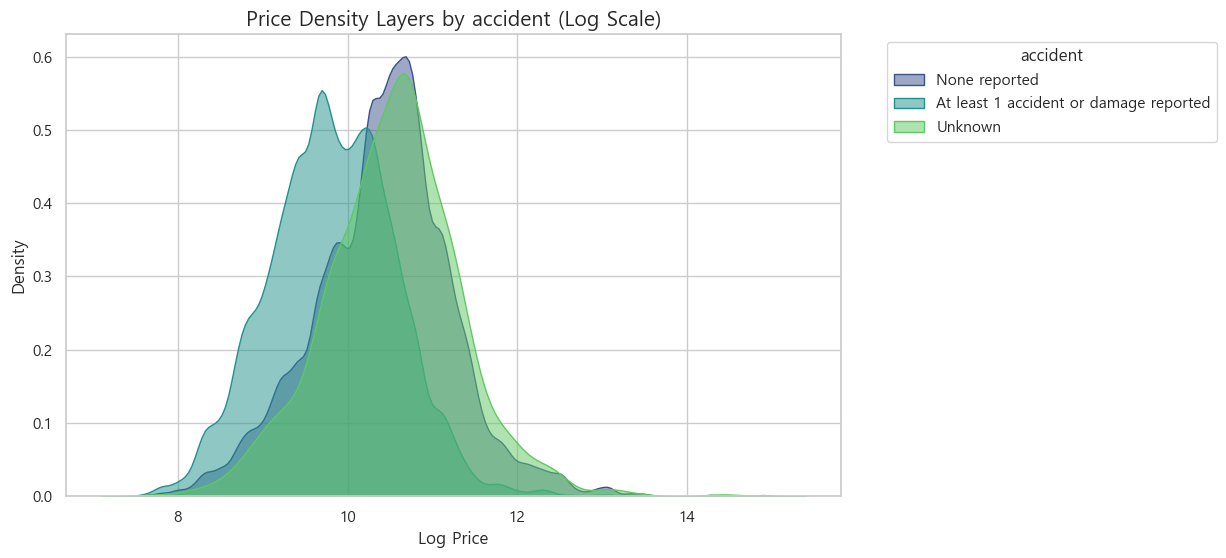

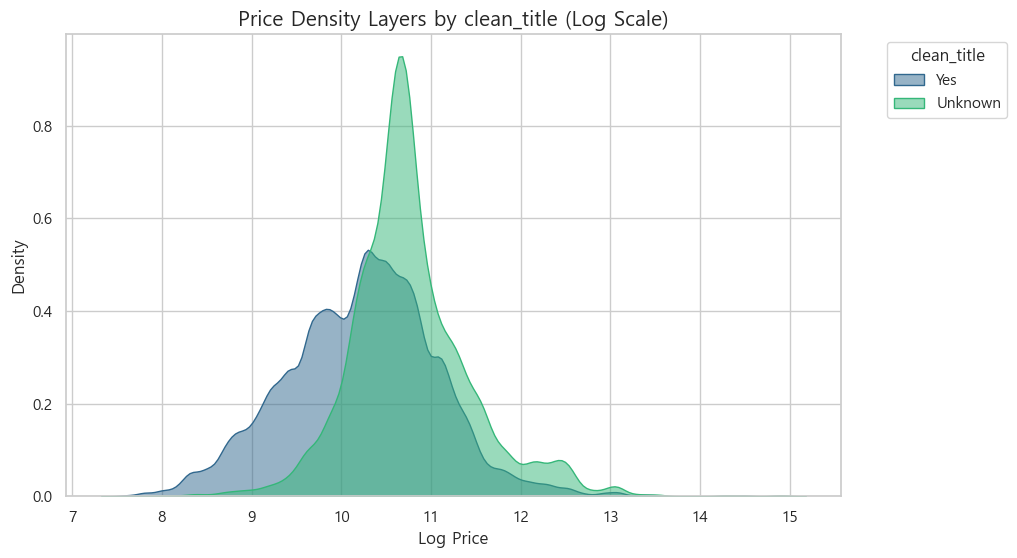

In [11]:
check_cols = [
    'fuel_type',
    'accident',
    'clean_title'
]


def plot_ridgeline(df, col, target='price'):
    # 가격이 너무 크면 로그 변환해서 보는 것이 훨씬 예쁩니다.
    df_plot = df.copy()
    df_plot[target] = np.log1p(df_plot[target])
    
    plt.figure(figsize=(10, 6))
    # 카테고리별로 색상을 다르게 설정
    unique_vals = df_plot[col].unique()
    colors = sns.color_palette("viridis", len(unique_vals))
    
    for i, val in enumerate(unique_vals):
        subset = df_plot[df_plot[col] == val]
        sns.kdeplot(subset[target], label=val, fill=True, alpha=0.5, color=colors[i])
    
    plt.title(f'Price Density Layers by {col} (Log Scale)', fontsize=15)
    plt.xlabel('Log Price')
    plt.ylabel('Density')
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# 사용 예시
for col in check_cols:
    plot_ridgeline(train_df, col)
    

C:\Users\subin\AppData\Local\Temp\ipykernel_11636\305515514.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='accident', y='price', palette='Set2')


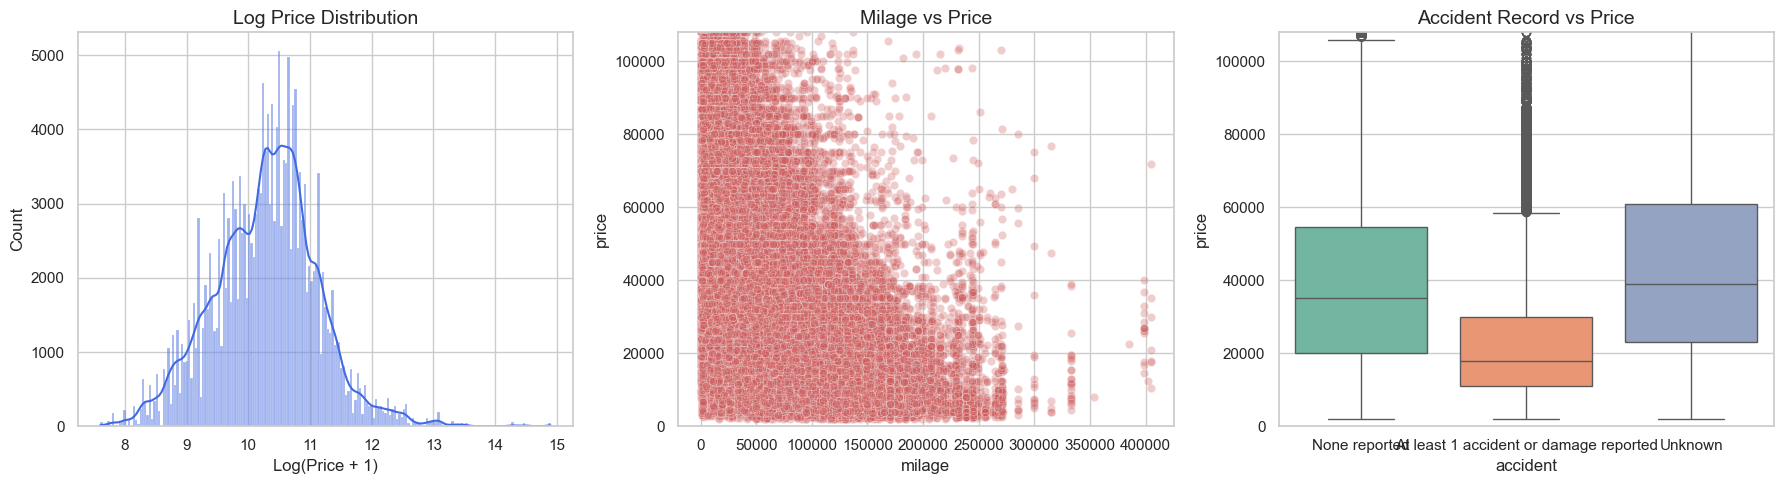

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 스타일 설정
sns.set_theme(style="whitegrid")

# 3가지 주요 지표를 한 번에 확인
plt.figure(figsize=(18, 5))

# 1. Price Distribution (Log Scale)
# 가격의 편차가 크므로 로그 변환을 통해 분포를 더 명확히 봅니다.
plt.subplot(1, 3, 1)
sns.histplot(np.log1p(train_df['price']), kde=True, color='royalblue')
plt.title('Log Price Distribution', fontsize=14)
plt.xlabel('Log(Price + 1)')

# 2. Milage vs Price (Regression Analysis)
# 주행거리와 가격의 음의 상관관계를 확인합니다.
plt.subplot(1, 3, 2)
sns.scatterplot(data=train_df, x='milage', y='price', alpha=0.3, color='indianred')
plt.title('Milage vs Price', fontsize=14)
plt.ylim(0, train_df['price'].quantile(0.95)) # 상위 5% 가격 제외하고 보기 (시인성)

# 3. Accident vs Price (Categorical Analysis)
# 사고 유무가 가격에 미치는 실질적인 영향을 확인합니다.
plt.subplot(1, 3, 3)
sns.boxplot(data=train_df, x='accident', y='price', palette='Set2')
plt.title('Accident Record vs Price', fontsize=14)
plt.ylim(0, train_df['price'].quantile(0.95))

plt.tight_layout()
plt.show()

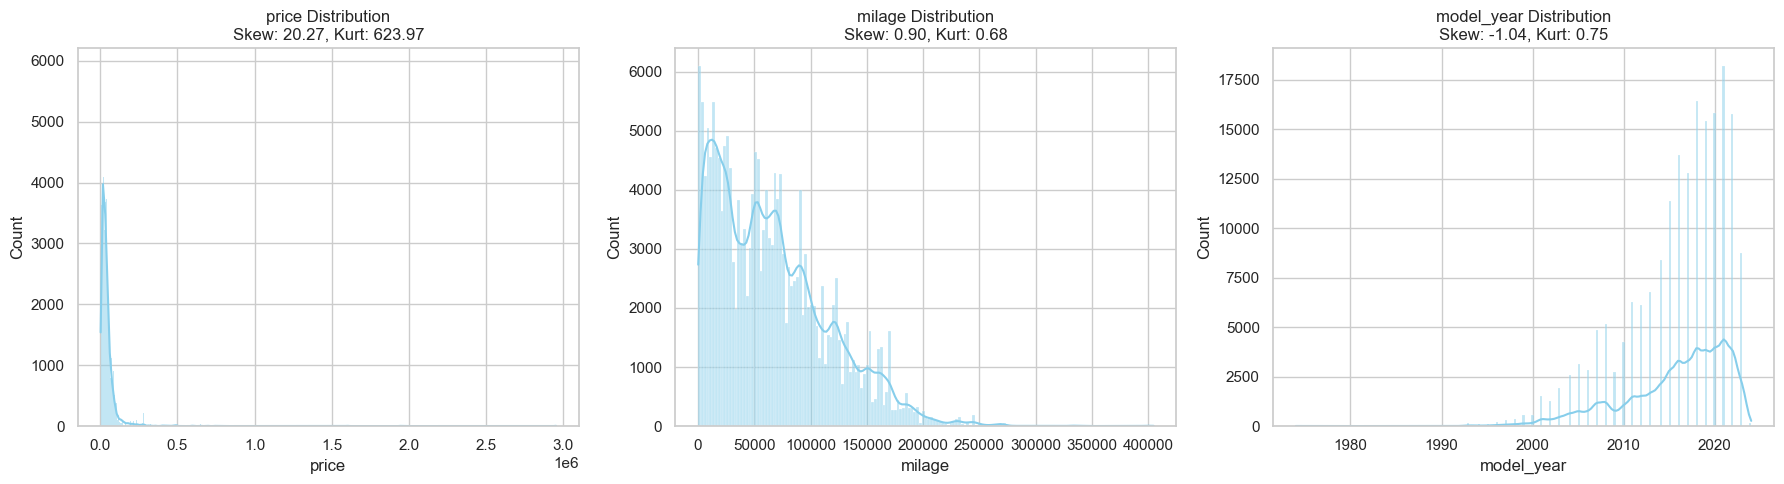

In [13]:
import scipy.stats as stats

features = ['price', 'milage', 'model_year']
plt.figure(figsize=(18, 5))

for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.histplot(train_df[col], kde=True, color='skyblue')
    
    # 왜도(Skewness)와 첨도(Kurtosis) 계산
    skew = train_df[col].skew()
    kurt = train_df[col].kurt()
    plt.title(f'{col} Distribution\nSkew: {skew:.2f}, Kurt: {kurt:.2f}')

plt.tight_layout()
plt.show()

#### 데이터 인사이트
* 정상 데이터 + 소수의 초고가 이상치 혼합
* 주행거리가 쩗을수록 가격이 높게 형성됨
* 모델 연식이 최신식일수록 가격이 높게 형성됨

C:\Users\subin\AppData\Local\Temp\ipykernel_11636\534975793.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_top10, y='brand', order=top_10_brands_list, palette='magma')
C:\Users\subin\AppData\Local\Temp\ipykernel_11636\534975793.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_fuel, x='fuel_type', y='price', palette='viridis', ci=None)
C:\Users\subin\AppData\Local\Temp\ipykernel_11636\534975793.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fuel, x='fuel_type', y='price', palette='viridis', ci=None)


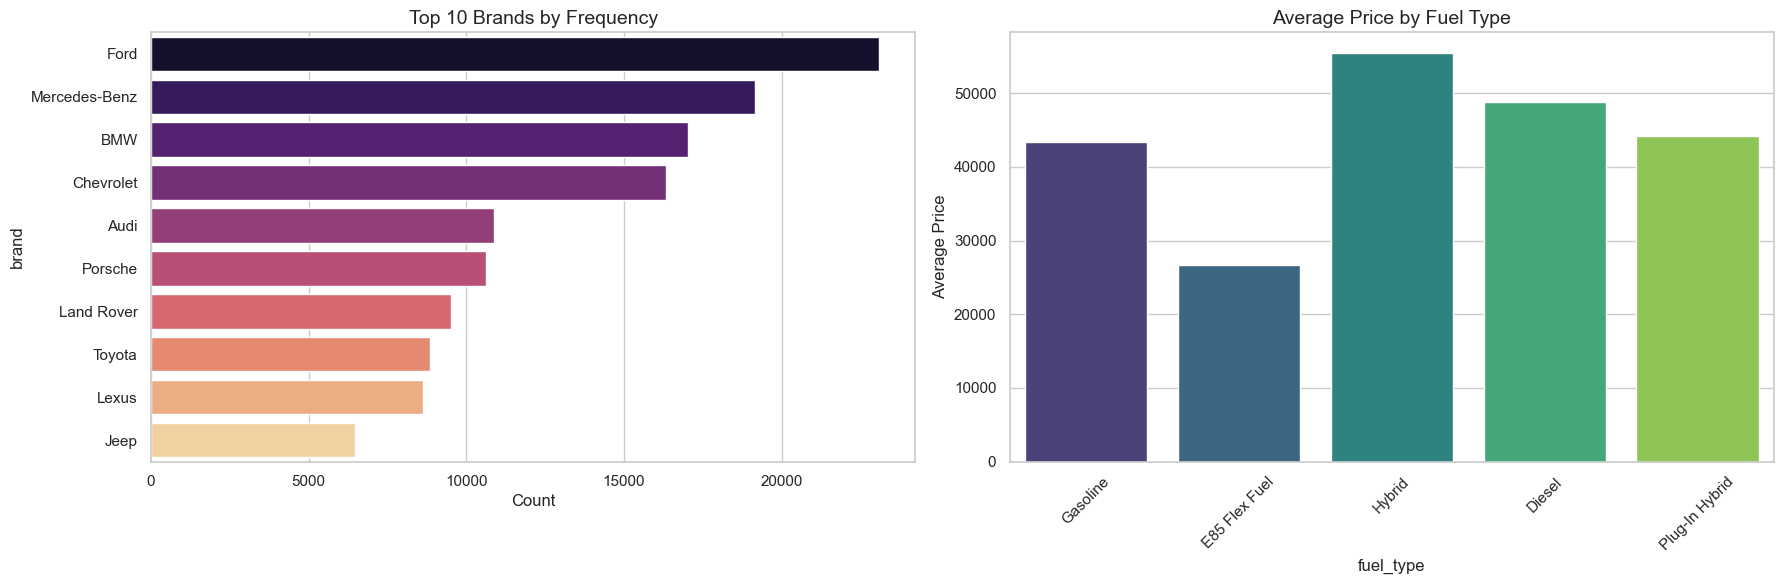

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터가 가장 많은 브랜드 TOP 10 추출
top_10_brands_list = train_df['brand'].value_counts().head(10).index
df_top10 = train_df[train_df['brand'].isin(top_10_brands_list)]

plt.figure(figsize=(18, 6))

# 그래프 1: 브랜드별 데이터 개수 (Market Share)
plt.subplot(1, 2, 1)
sns.countplot(data=df_top10, y='brand', order=top_10_brands_list, palette='magma')
plt.title('Top 10 Brands by Frequency', fontsize=14)
plt.xlabel('Count')

# 그래프 2: 연료 타입별 평균 가격 (Fuel Type vs Price)
# 데이터가 적은 '–', 'not supported' 등은 제외하고 주요 타입만 비교
main_fuels = ['Gasoline', 'Hybrid', 'Diesel', 'E85 Flex Fuel', 'Plug-In Hybrid']
df_fuel = train_df[train_df['fuel_type'].isin(main_fuels)]

plt.subplot(1, 2, 2)
sns.barplot(data=df_fuel, x='fuel_type', y='price', palette='viridis', ci=None)
plt.title('Average Price by Fuel Type', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Average Price')

plt.tight_layout()
plt.show()

* 평균값으로 보았을 땐 상대적으로 하이브리드나 전기차량이 시중에 나온지 얼마 되지 않았기 때문에 고가로 거래된 차량이 많을 수 있음.

C:\Users\subin\AppData\Local\Temp\ipykernel_11636\2782527270.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxenplot(x='fuel_type', y='price', data=train_df,


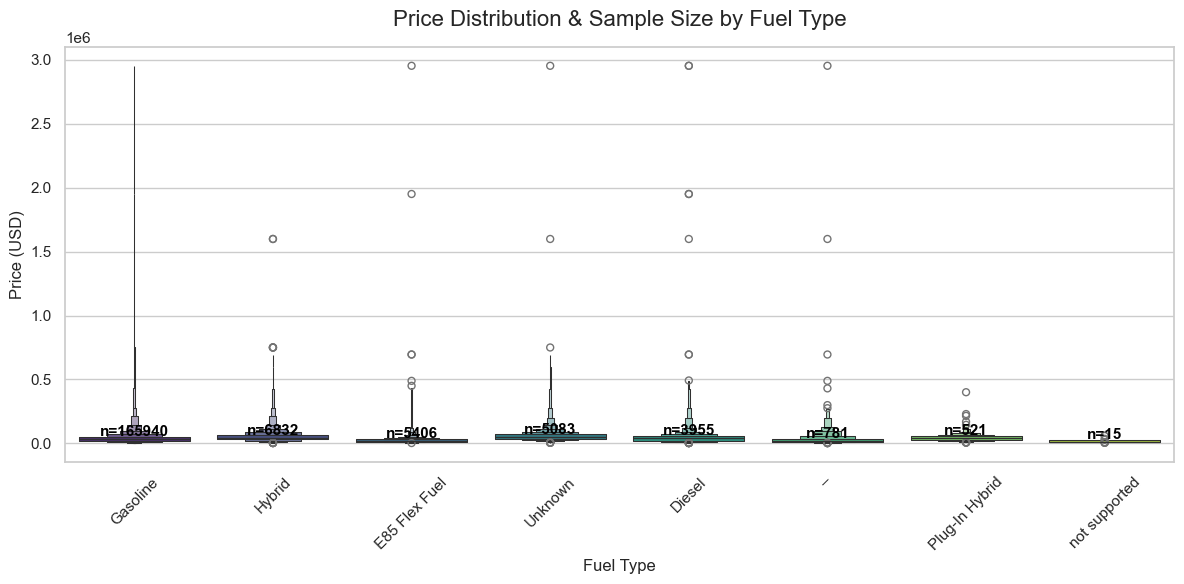

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# 1. Sort by data count for better readability
fuel_order = train_df['fuel_type'].value_counts().index
fuel_counts = train_df['fuel_type'].value_counts()

# 2. Draw Boxen Plot (Enhanced box plot for large datasets)
# It shows more quantiles than a standard box plot
ax = sns.boxenplot(x='fuel_type', y='price', data=train_df, 
                   order=fuel_order, palette='viridis')

# 3. Annotate sample size (n=...) on each box
for i, fuel in enumerate(fuel_order):
    count = fuel_counts[fuel]
    # Position the text at the median price of each category
    median_val = train_df[train_df['fuel_type'] == fuel]['price'].median()
    
    plt.text(i, median_val, f'n={count}', 
             ha='center', va='bottom', 
             color='black', fontweight='bold', fontsize=11)

# 4. Final Formatting in English
plt.title('Price Distribution & Sample Size by Fuel Type', fontsize=16, pad=15)
plt.xlabel('Fuel Type', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

* 압도적으로 가솔린 차의 대수가 많고, 가격 편차도 심한편.

In [16]:
brand_stats = train_df.groupby('brand')['price'].agg(['mean', 'max', 'count']).sort_values(by='mean', ascending=False)

# 3. 상위 15개 브랜드 출력
print("### Top 15 Brands by Average Price ###")
print(brand_stats.head(15))

### Top 15 Brands by Average Price ###
                       mean      max  count
brand                                      
Bugatti       169600.000000   259500      7
Lamborghini   159176.012361  1950995    809
Rolls-Royce   135488.650624  1950995    561
Bentley       129272.933333  2954083   1155
McLaren       123261.238683   599000    243
Ferrari       116751.005571  1599000    359
Aston Martin  112364.588235  2954083    238
Rivian         81089.154237   695000    590
Porsche        70899.947795  1950995  10612
Lucid          63310.362319   279950     69
Maserati       61459.699681   749950    939
Tesla          56445.274746  2954083   3738
Maybach        53566.333333    90200      3
Genesis        53556.327141  1599000    969
Land Rover     53204.880000  2954083   9525


In [17]:
# 가격 기준 내림차순 정렬하여 상위 20개 출력
top_price_cars = train_df.sort_values(by='price', ascending=False).head(5)

# 주요 컬럼들만 선택해서 보기 편하게 출력
print(top_price_cars[['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'price']])

                brand                              model  model_year  milage  \
14693         Hyundai                       Santa Fe SEL        2022   13865   
1880         Chrysler                          300C Base        2003   55900   
65043   Mercedes-Benz  AMG GLE AMG GLE 63 S-Model 4MATIC        2017    4590   
103061            RAM               1500 Classic Warlock        2019   36757   
59650          Toyota                     Highlander XLE        2022   13566   

       fuel_type                                        engine    price  
14693   Gasoline                          2.5L I4 16V PDI DOHC  2954083  
1880    Gasoline  340.0HP 5.7L 8 Cylinder Engine Gasoline Fuel  2954083  
65043   Gasoline  577.0HP 5.5L 8 Cylinder Engine Gasoline Fuel  2954083  
103061  Gasoline                          5.7L V8 16V MPFI OHV  2954083  
59650   Gasoline                    2.4L I4 16V PDI DOHC Turbo  2954083  


In [18]:
# 1. 문제의 가격을 가진 데이터가 몇 개인지 확인
problematic_price = 2954083
error_count = train_df[train_df['price'] == problematic_price].shape[0]
print(f"Number of error data points: {error_count}")

Number of error data points: 50


* 브랜드와 모델을 확인결과 실제 거래 가격과 차이가 많이 나지만 합성데이터이기 때문.

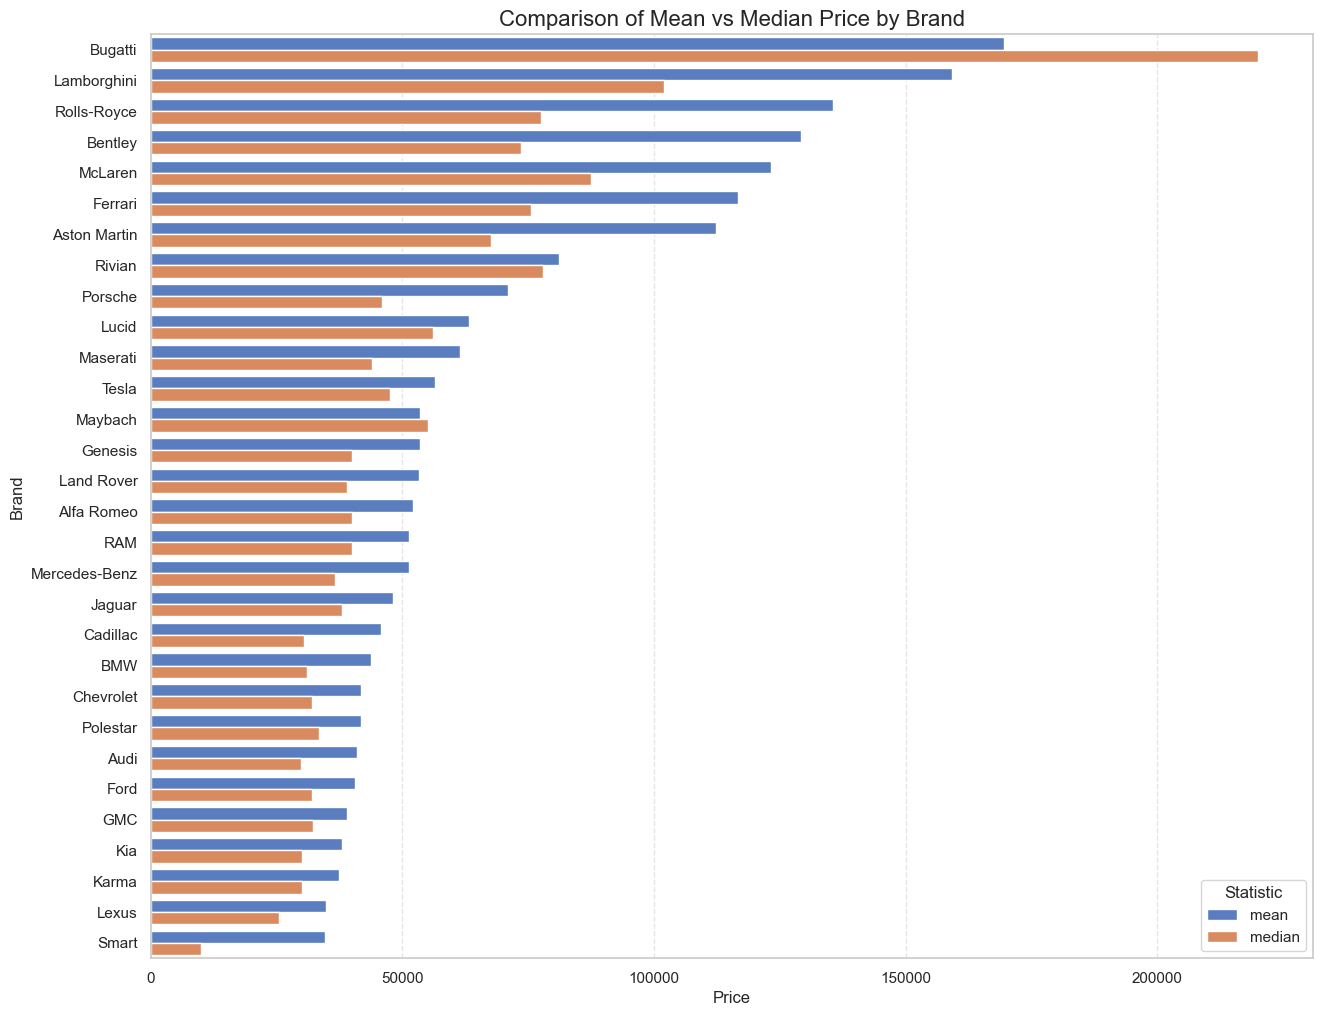

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 브랜드별 평균과 중앙값 계산
brand_stats = train_df.groupby('brand')['price'].agg(['mean', 'median', 'count'])

# 2. 비교를 위해 평균 기준 상위 30개 추출
top_30_stats = brand_stats.sort_values(by='mean', ascending=False).head(30)

# 3. 시각화를 위한 데이터 재구성 (Tidy format)
plot_data = top_30_stats[['mean', 'median']].reset_index().melt(id_vars='brand', var_name='Type', value_name='Price')

# 4. 시각화
plt.figure(figsize=(15, 12))
sns.barplot(data=plot_data, y='brand', x='Price', hue='Type', palette='muted')

plt.title('Comparison of Mean vs Median Price by Brand', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Brand', fontsize=12)
plt.legend(title='Statistic')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

* 브랜드별로 거래 가격의 중앙값, 평균값 확인

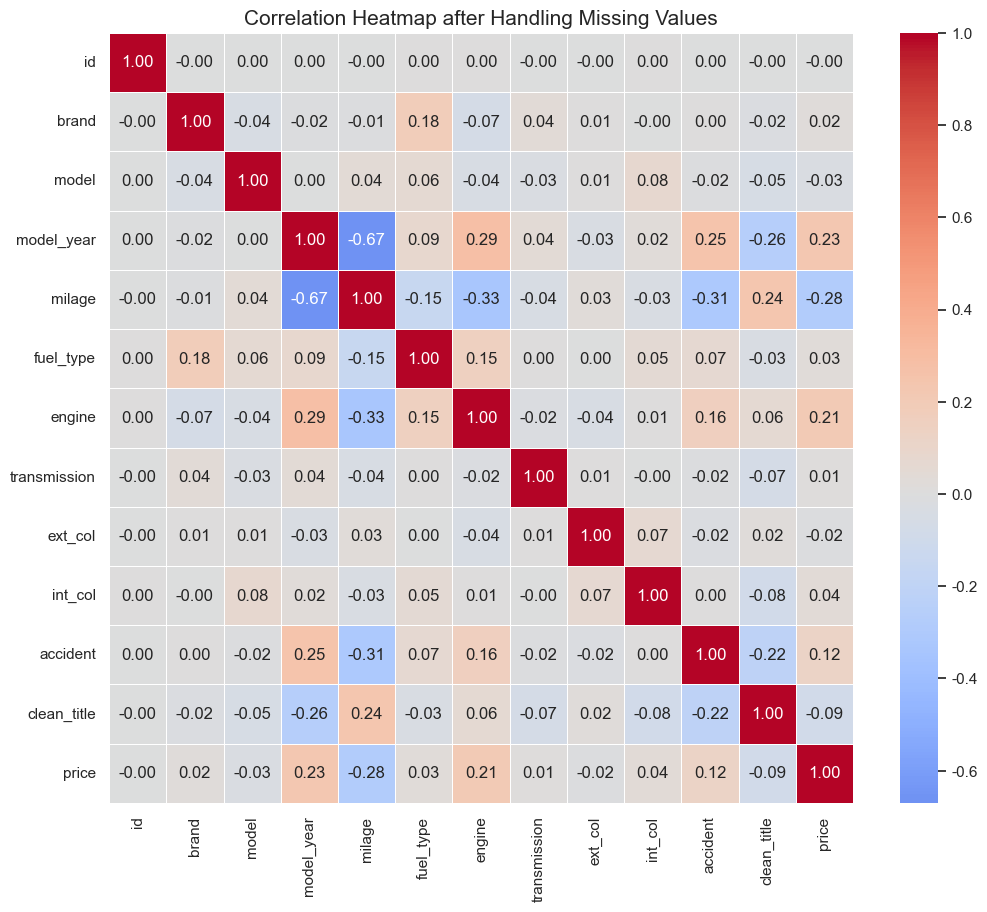

In [20]:
from sklearn.preprocessing import LabelEncoder

# 1. Copy data for visualization
df_visual = train_df.copy()

# 2. Label Encoding for Categorical Columns
# We need to convert strings to numbers for the correlation matrix
le = LabelEncoder()
categorical_cols = df_visual.select_dtypes(include=['object']).columns

for col in categorical_cols:
    df_visual[col] = le.fit_transform(df_visual[col].astype(str))

# 3. Calculate Correlation Matrix
# This includes 'price' and all numerical/encoded categorical columns
corr_matrix = df_visual.corr()

# 4. Visualize Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            annot=True,       
            fmt=".2f",        
            cmap='coolwarm',  
            center=0,         
            linewidths=0.5)   

plt.title('Correlation Heatmap after Handling Missing Values', fontsize=15)
plt.show()

### 🔎 중간 인사이트 요약 (Correlation & Distribution 기반)

* **브랜드(Brand)**\
  브랜드가 높다고 해서 모든 차량의 가격이 일관되게 높은 것은 아니며, 동일 브랜드 내에서도 가격 분산과 이상치가 다수 존재한다.
  이에 따라 **브랜드 자체는 가격과 강한 직접적 상관관계를 갖지 않는 변수**로 해석할 수 있다.

* **모델 연식(Model Year)**\
  모델 연식이 최신일수록 차량 가격이 높아지는 경향이 명확하게 관찰된다.
  이는 중고차 가격 형성에서 **시간에 따른 감가상각이 핵심 요인**임을 시사한다.

* **주행거리(Mileage)**\
  주행거리가 짧을수록 가격이 높아지는 음의 상관관계가 확인되며,
  특히 동일 연식 내에서는 **상대적으로 낮은 주행거리가 가격 방어 요인**으로 작용한다.

* **엔진 및 연료 타입(Engine / Fuel Type)**\
  가솔린 차량의 비중이 절대적으로 높지만,
  하이브리드 및 전기차의 경우 평균적으로 더 높은 가격대를 형성하고 있어
  **연료 타입에 따른 프리미엄 효과**가 존재함을 시사한다.

* **사고 이력(Accident)**\
  사고 이력이 없는 차량이 상대적으로 높은 가격을 형성하지만,
  accident 변수가 `unknown`으로 처리된 데이터가 존재하여 단순 상관계수는 제한적으로 나타난다.
  다만 이상치를 제외한 분포 기준으로 볼 때, **사고 경험이 있는 차량은 평균적으로 더 저렴한 경향**을 보인다.


In [21]:
import re

def extract_engine_features(df):
    # 마력(HP) 추출
    df['horsepower'] = df['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
    # 배기량(L) 추출 
    df['displacement'] = df['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
    
    # 결측치는 평균이나 중앙값으로 채우기
    df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())
    df['displacement'] = df['displacement'].fillna(df['displacement'].median())
    return df

train_df = extract_engine_features(train_df)
test_df = extract_engine_features(test_df)

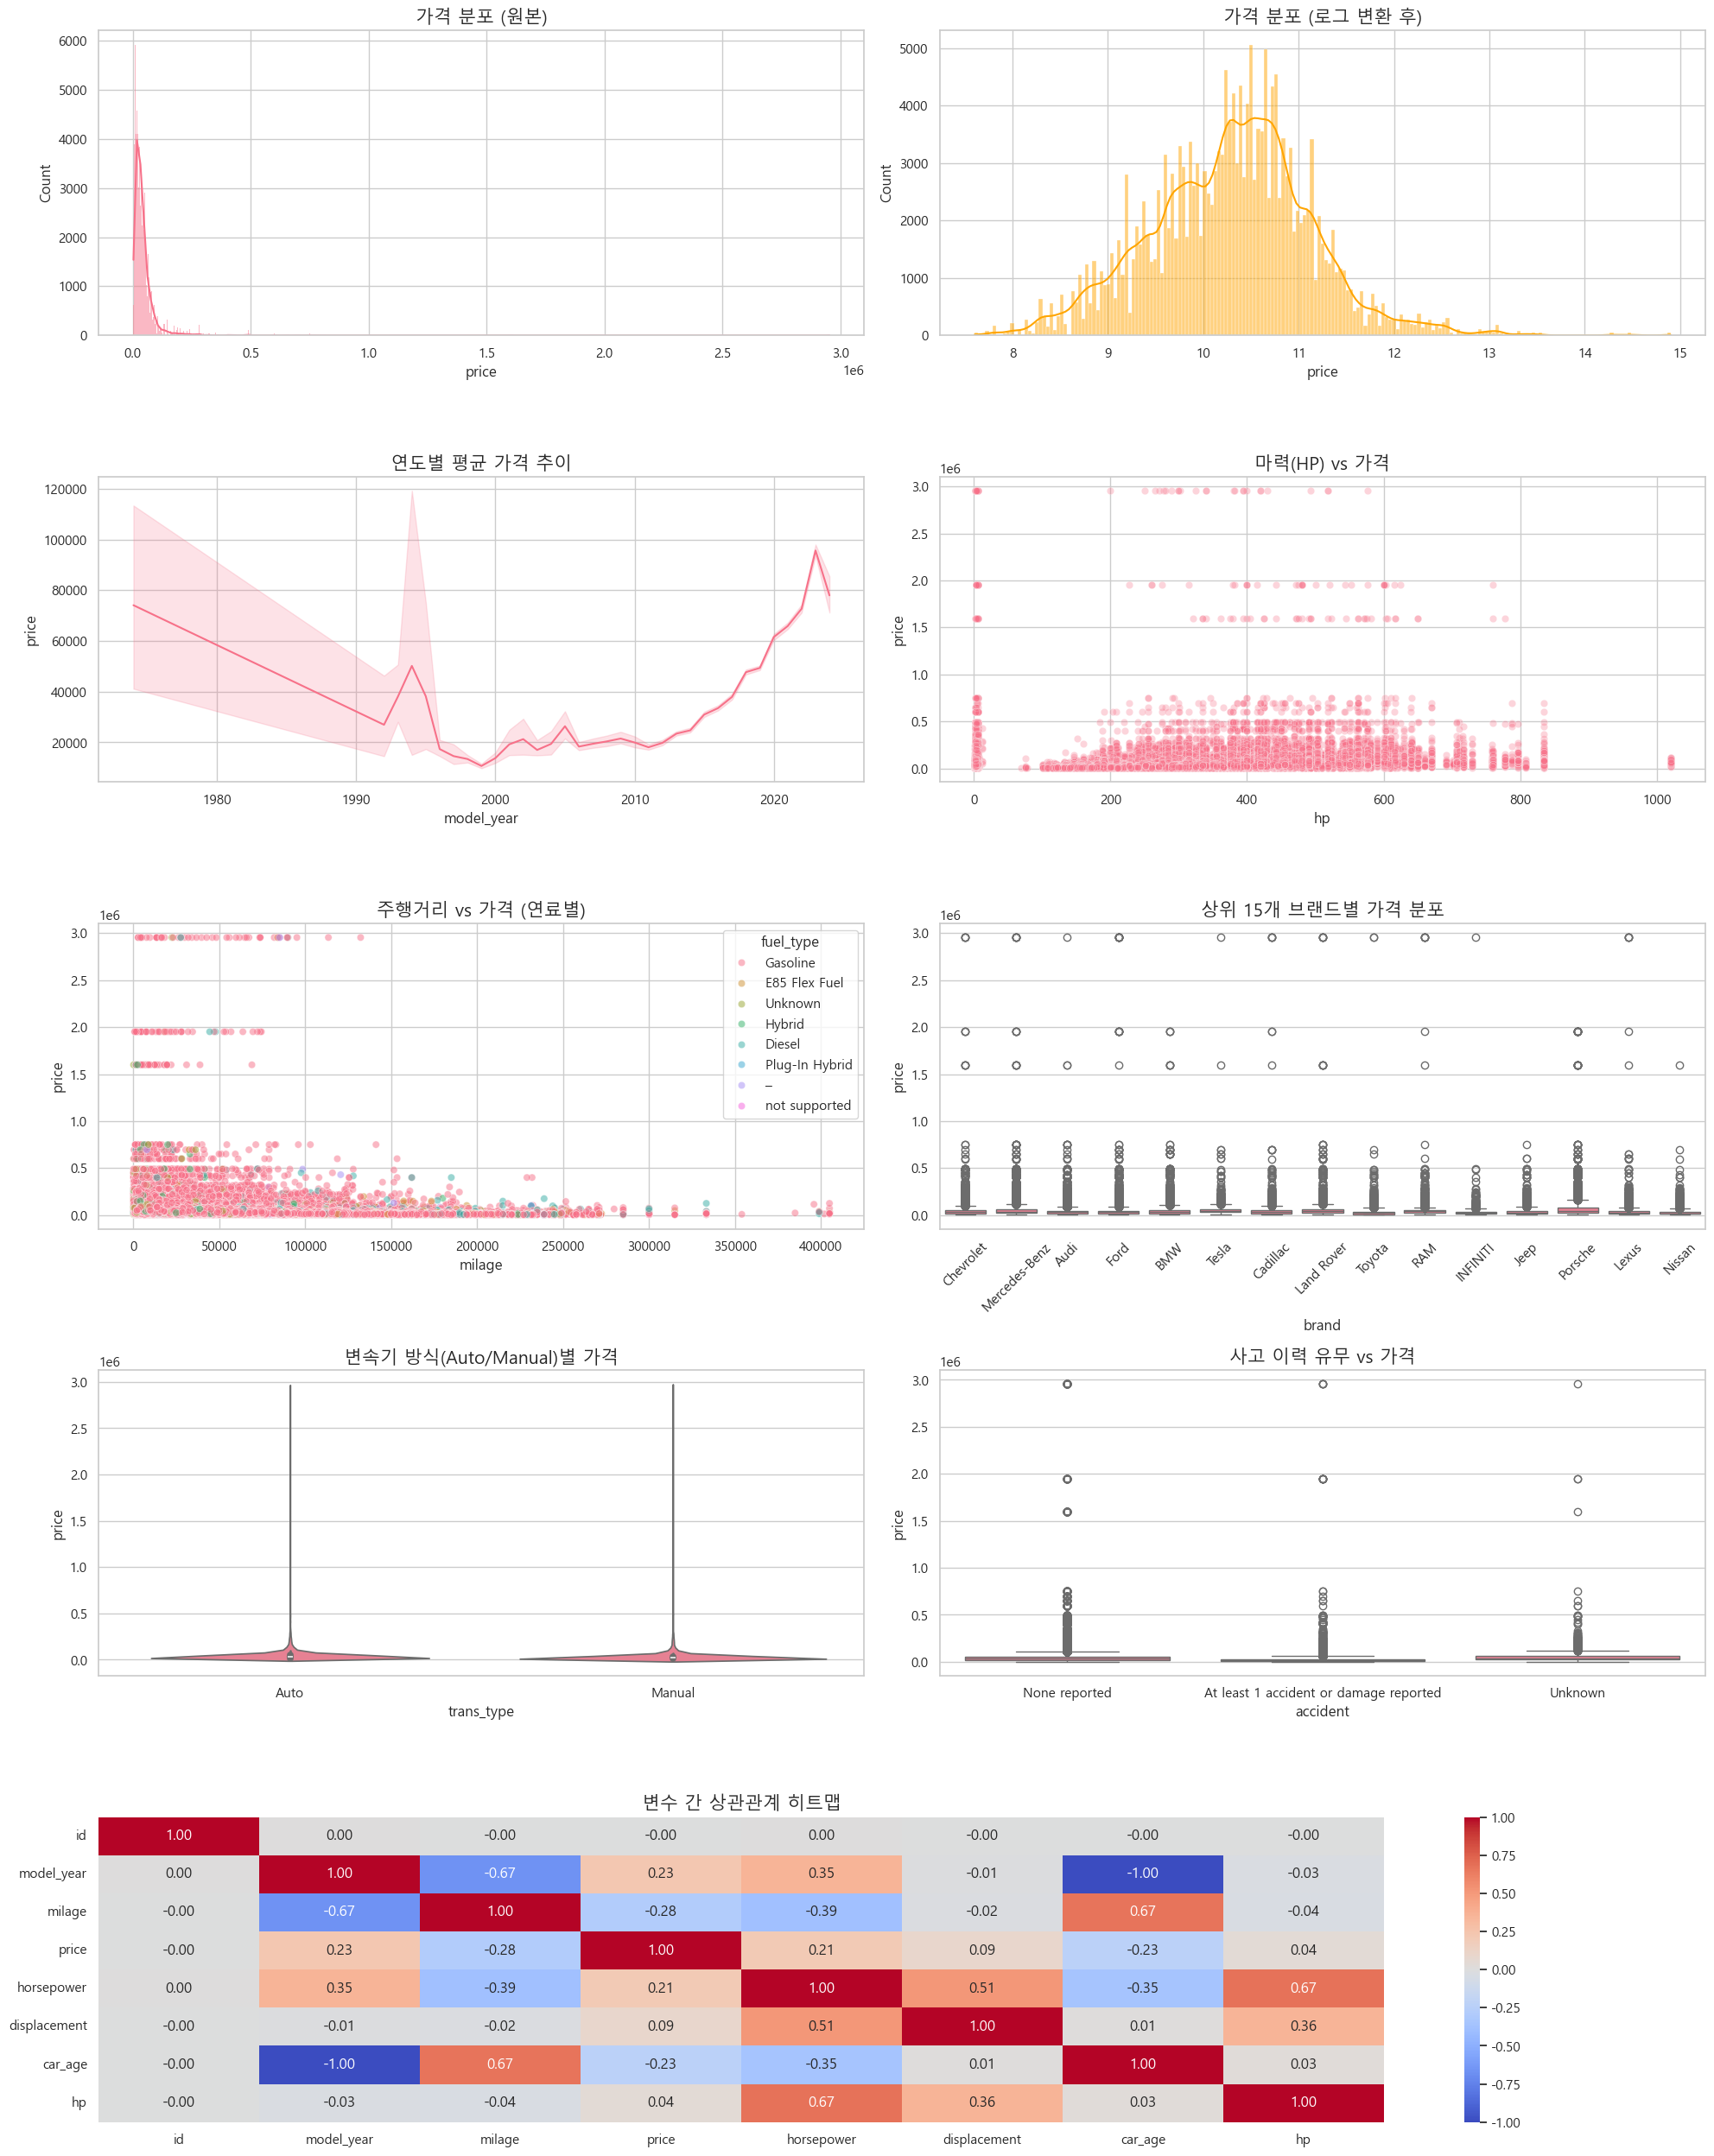

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# 한글 폰트 설정 (Windows: Malgun Gothic, Mac: AppleGothic)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

def run_advanced_eda(df):
    df = df.copy()
    
    # 1. 연식 계산
    df['car_age'] = 2024 - df['model_year'] # 현재 연도 기준
    
    # 2. 마력(HP) 추출: 'engine' 컬럼에서 숫자만 가져오기
    if 'engine' in df.columns:
        df['hp'] = df['engine'].str.extract('(\d+\.?\d*)').astype(float)

    if 'transmission' in df.columns:
        df['trans_type'] = df['transmission'].apply(
            lambda x: 'Auto' if any(kw in str(x).lower() for kw in ['auto', 'a/t', 'shift']) else 'Manual'
        )

    # --- 시각화 시작 ---
    fig = plt.figure(figsize=(20, 30))
    gs = gridspec.GridSpec(6, 2, figure=fig)
    sns.set_palette("husl")

    # [1] 가격 분포 (로그 변환 필수 여부 판단)
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(df['price'], kde=True, ax=ax1)
    ax1.set_title('가격 분포 (원본)', fontsize=15)

    ax2 = fig.add_subplot(gs[0, 1])
    sns.histplot(np.log1p(df['price']), kde=True, ax=ax2, color='orange')
    ax2.set_title('가격 분포 (로그 변환 후)', fontsize=15)

    # [2] 연식 vs 가격 (감가상각 확인)
    ax3 = fig.add_subplot(gs[1, 0])
    sns.lineplot(data=df, x='model_year', y='price', ax=ax3)
    ax3.set_title('연도별 평균 가격 추이', fontsize=15)

    # [3] 마력(HP) vs 가격 (엔진 성능의 영향력)
    ax4 = fig.add_subplot(gs[1, 1])
    if 'hp' in df.columns:
        sns.scatterplot(data=df, x='hp', y='price', alpha=0.3, ax=ax4)
        ax4.set_title('마력(HP) vs 가격', fontsize=15)

    # [4] 주행거리(Milage) vs 가격 (연료 타입별 비교)
    ax5 = fig.add_subplot(gs[2, 0])
    sns.scatterplot(data=df, x='milage', y='price', hue='fuel_type', alpha=0.5, ax=ax5)
    ax5.set_title('주행거리 vs 가격 (연료별)', fontsize=15)

    # [5] 브랜드별 가격 (상위 15개)
    ax6 = fig.add_subplot(gs[2, 1])
    top_brands = df['brand'].value_counts().head(15).index
    sns.boxplot(data=df[df['brand'].isin(top_brands)], x='brand', y='price', ax=ax6)
    ax6.set_title('상위 15개 브랜드별 가격 분포', fontsize=15)
    ax6.tick_params(axis='x', rotation=45)

    # [6] 변속기 타입별 가격 (파일 1 전처리 반영)
    ax7 = fig.add_subplot(gs[3, 0])
    sns.violinplot(data=df, x='trans_type', y='price', ax=ax7)
    ax7.set_title('변속기 방식(Auto/Manual)별 가격', fontsize=15)

    # [7] 사고 유무 vs 가격
    ax8 = fig.add_subplot(gs[3, 1])
    if 'accident' in df.columns:
        sns.boxplot(data=df, x='accident', y='price', ax=ax8)
        ax8.set_title('사고 이력 유무 vs 가격', fontsize=15)

    # [8] 상관관계 히트맵 (수치형 변수)
    ax9 = fig.add_subplot(gs[4, :])
    corr = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', ax=ax9)
    ax9.set_title('변수 간 상관관계 히트맵', fontsize=15)


    plt.tight_layout()
    plt.show()

run_advanced_eda(train_df)

## 1. 🚗 중고차 가격 형성의 4대 핵심 동력 (최종 정리)

| 구분           | 데이터 기반 핵심 분석 결론                                                |
| ------------ | -------------------------------------------------------------- |
| **시간 요인**    | **연식(vehicle_age)** 은 가격의 기준축이며, 감가의 방향과 속도를 가장 강하게 규정함        |
| **사용량 요인**   | **주행거리(mileage)** 는 단독 영향력보다 **연식 대비 상대적 사용량**일 때 가격 설명력이 극대화됨 |
| **성능 요인**    | **엔진/마력(engine, hp)** 은 가격 상승 요인이지만, 단독 효과는 제한적임               |
| **신뢰·상태 요인** | **사고 이력(accident)** 과 **타이틀 상태(clean_title)** 는 명확한 감가 신호로 작동함 |

---

## 2. 🕒 연식 & 주행거리 핵심 인사이트

### **“상관관계가 아니라 제약 구조”**

* model_year ↔ mileage 상관계수 **-0.67**

  * 이는 의미 있는 ‘관계’가 아니라 **누적 시간에 따른 물리적 제약**
* 연식은 주행거리의 **가능 범위(상한)** 를 결정
* 동일 mileage라도:

  * 최근 연식 → 감가 요인
  * 오래된 연식 → 관리 상태 긍정 신호

📌 **결론**

> 절대 주행거리보다
> **연식 대비 기대 주행거리에서 얼마나 벗어났는가**가 가격에 직접적으로 작용함

---

## 3. 🏷️ 브랜드 인사이트 재정의

### **“브랜드는 좋고 나쁨의 문제가 아니다”**

| 관찰                          | 데이터 해석                  |
| --------------------------- | ----------------------- |
| brand ↔ price 상관 ≈ **0.02** | 브랜드 단독으로는 가격을 설명하지 못함   |
| brand ↔ fuel_type **0.18**  | 브랜드 효과는 연료/차급과 결합되어 나타남 |
| 브랜드별 가격 분산 큼                | 동일 브랜드 내에서도 가격 폭이 매우 넓음 |

📌 **핵심 인사이트**

* 브랜드는 **프리미엄 보증 변수 ❌**
* 브랜드의 역할은:

  * 평균 가격 상승이 아니라
  * **가격의 상한(Ceiling)을 허용하는 조건**
* “브랜드가 좋아서 비싸다”가 아니라
  **“비싼 차들이 주로 그 브랜드에 존재한다”**

👉 브랜드는 **조건 변수이지 절대 평가 변수 아님**

---

## 4. ⚙️ 성능·엔진 관련 인사이트

| 항목               | 관찰        | 해석               |
| ---------------- | --------- | ---------------- |
| engine ↔ price   | **+0.21** | 성능 프리미엄 존재       |
| hp ↔ price       | 약한 양의 관계  | 고가 차량의 필요 조건     |
| engine ↔ mileage | **-0.33** | 고성능 차량일수록 저주행 경향 |

📌 **결론**

* 성능은 가격 상승에 기여하지만,
* 브랜드·연식과 결합되지 않으면 영향력 제한적

---

## 5. 🚧 사고·타이틀 상태 인사이트

| 변수                  | 관찰된 상관    | 핵심 해석              |
| ------------------- | --------- | ------------------ |
| accident ↔ price    | **+0.12** | 사고 없음이 가격 방어       |
| accident ↔ mileage  | **-0.31** | 고주행 차량일수록 사고 기록 많음 |
| clean_title ↔ price | **-0.09** | 타이틀 이슈는 명확한 감가     |

📌 **중요 포인트**

* accident = categorical signal
* Unknown은 None과 다르며, **독립적인 정보 상태**

---

## 6. 📊 상관관계 히트맵이 말해주는 진짜 메시지

* price와 가장 관련 있는 변수들도 상관계수는 **0.2~0.3 수준**
* 이는:

  * 데이터가 나쁜 게 아니라
  * **가격이 단일 요인으로 결정되지 않는 구조**라는 증거

📌 **이 데이터의 본질**

> 가격은 “어떤 변수 하나의 결과”가 아니라
> **시간·사용량·성능·신뢰 상태가 겹쳐 만들어지는 조건부 결과**

---

## 7. 🧠 최종 통합 결론 (Final Summary)

> **“중고차 가격은 브랜드가 좋다고 자동으로 높아지지 않는다.
> 연식이 만든 시간적 한계 안에서,
> 연식 대비 얼마나 사용되었는지,
> 어떤 성능과 상태를 가졌는지가 결합될 때 가격이 형성된다.
> 즉, 핵심은 ‘브랜드의 이름’이 아니라
> 그 조건 속에서의 상대적 위치다.”**

---



### 전처리 단계

In [32]:
import pandas as pd
import numpy as np

def final_preprocess(df, is_train=True):
    df = df.copy()
    
    # [중요] 이상치 제거: 0.4점대 복구를 위해 너무 높은 가격은 제거 (학습시에만)
    # 만약 이전에 특정 가격 이상을 지우셨다면 그 수치로 조정하세요.
    if is_train:
        df = df[df['price'] < 200000].reset_index(drop=True) 

    # 1. 범주형 결측치 처리 및 타입 고정
    cat_cols = ['brand', 'model', 'fuel_type', 'accident', 'clean_title']
    for col in cat_cols:
        df[col] = df[col].fillna('Unknown').astype(str)
    
    # 2. 엔진 정보 추출
    df['horsepower'] = df['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
    df['engine_size'] = df['engine'].str.extract(r'(\d+\.?\d*)L').astype(float)
    df['cylinders'] = df['engine'].str.extract(r'(\d+)\s*Cylinder').astype(float)
    
    # 수치형 결측치 중앙값 채우기
    num_cols = ['horsepower', 'engine_size', 'cylinders']
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    # 3. 브랜드 티어링 & 파생 변수
    def categorize_brand(brand):
        brand = str(brand).lower()
        if brand in ['ferrari', 'lamborghini', 'bentley', 'rolls-royce', 'mclaren', 'aston martin']: return 'Ultra'
        if brand in ['porsche', 'mercedes-benz', 'bmw', 'audi', 'land rover', 'lexus']: return 'Premium'
        return 'Mainstream'
    
    df['brand_tier'] = df['brand'].apply(categorize_brand).astype(str)
    df['car_age'] = 2026 - df['model_year']
    df['milage_per_year'] = df['milage'] / (df['car_age'] + 1)
    df['is_high_trim'] = df['model'].str.contains('AMG|M Sport|Sport|Limited|GT', case=False, na=False).astype(int)
    
    return df

# 적용 (변수명 train_df, test_df 사용)
train_processed = final_preprocess(train_df, is_train=True)
test_processed = final_preprocess(test_df, is_train=False)

final_features = ['brand', 'model', 'model_year', 'milage', 'fuel_type', 'horsepower', 
                  'accident', 'clean_title', 'engine_size', 'cylinders', 'car_age', 
                  'milage_per_year', 'brand_tier', 'is_high_trim']
final_cat_features = ['brand', 'model', 'fuel_type', 'accident', 'clean_title', 'brand_tier']

X = train_processed[final_features]
y_log = np.log1p(train_processed['price'])
X_test = test_processed[final_features]

In [33]:
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
import time

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds_log = np.zeros(len(X))
test_preds_log = np.zeros(len(X_test))

print("⚡ 초고속 모드로 학습 시작 (약 2~3분 예상)...")
start_time = time.time()

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y_log)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_log.iloc[train_idx], y_log.iloc[val_idx]
    
    # 시간을 줄이기 위해 iterations를 500으로 하향 조정
    model = CatBoostRegressor(
        iterations=500,          # 3000에서 500으로 줄임
        learning_rate=0.1,       # 학습 속도를 높이기 위해 상향
        depth=6,                 # 깊이를 줄여 연산량 감소
        eval_metric='RMSE',
        random_seed=42,
        verbose=0,
        # task_type='GPU'        # GPU 사용 가능 환경이면 주석 해제하세요
    )
    
    model.fit(X_train, y_train, cat_features=final_cat_features, eval_set=(X_val, y_val), early_stopping_rounds=50)
    
    oof_preds_log[val_idx] = model.predict(X_val)
    test_preds_log += (model.predict(X_test) / 5)
    print(f"Fold {fold+1} 완료")

end_time = time.time()
print(f"✨ 전체 학습 소요 시간: {(end_time - start_time)/60:.2f}분")

# 성능 확인
y_true = np.expm1(y_log)
y_pred = np.expm1(oof_preds_log)
print(f"✅ 최종 복원 R2 Score: {r2_score(y_true, y_pred):.4f}")

⚡ 초고속 모드로 학습 시작 (약 2~3분 예상)...
Fold 1 완료
Fold 2 완료
Fold 3 완료
Fold 4 완료
Fold 5 완료
✨ 전체 학습 소요 시간: 4.38분
✅ 최종 복원 R2 Score: 0.5213


In [34]:
submission = pd.DataFrame({'id': test_df['id'], 'price': np.expm1(test_preds_log)})
submission.to_csv('final_submit.csv', index=False)